In [12]:
import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from tensorboardX import SummaryWriter
import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        y = self.relu(self.fc2(y))
        Q = self.fc3(y)

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


env = gym.make('CartPole-v0')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 16

UPDATE_STEPS = 16

memory_replay = Memory(REPLAY_MEMORY)

epsilon = INITIAL_EPSILON
learn_steps = 0
writer = SummaryWriter('logs/dqn')
begin_learn = False


episode_reward = 0
reward_list=[]
loss_list=[]
for epoch in count():

    state = env.reset()
    episode_reward = 0
    train_loss=[]
    for time_steps in range(200):
        p = random.random()
        if p < epsilon:
            action = random.randint(0, 1)
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = onlineQNetwork.select_action(tensor_state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        memory_replay.add((state, next_state, action, reward, done))
        if memory_replay.size() > 128:
            if begin_learn is False:
                print('learn begin!')
                begin_learn = True
            learn_steps += 1
            if learn_steps % UPDATE_STEPS == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            batch = memory_replay.sample(BATCH, False)
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                targetQ_next = targetQNetwork(batch_next_state)
                y = batch_reward + (1 - batch_done) * GAMMA * torch.max(targetQ_next, dim=1, keepdim=True)[0]

            loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            writer.add_scalar('loss', loss.item(), global_step=learn_steps)

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
        
        if done:
            break
        state = next_state
    loss_list.append(np.mean(np.array(train_loss)))
    reward_list.append(episode_reward)
    if (len(reward_list)>100):
      
        if sum(reward_list[-100:])/100 >=199:
            print("Finished")
            break
    writer.add_scalar('episode reward', episode_reward, global_step=epoch)
    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'dqn-policy.para')
        print('Ep {}\tMoving average score: {:.2f}\t'.format(epoch, episode_reward))



C:\Users\xufan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\xufan\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep 0	Moving average score: 10.00	
Ep 10	Moving average score: 9.00	
learn begin!
Ep 20	Moving average score: 13.00	
Ep 30	Moving average score: 9.00	
Ep 40	Moving average score: 10.00	
Ep 50	Moving average score: 13.00	
Ep 60	Moving average score: 9.00	
Ep 70	Moving average score: 10.00	
Ep 80	Moving average score: 12.00	
Ep 90	Moving average score: 10.00	
Ep 100	Moving average score: 10.00	
Ep 110	Moving average score: 9.00	
Ep 120	Moving average score: 13.00	
Ep 130	Moving average score: 17.00	
Ep 140	Moving average score: 10.00	
Ep 150	Moving average score: 10.00	
Ep 160	Moving average score: 10.00	
Ep 170	Moving average score: 10.00	
Ep 180	Moving average score: 9.00	
Ep 190	Moving average score: 14.00	
Ep 200	Moving average score: 20.00	
Ep 210	Moving average score: 25.00	
Ep 220	Moving average score: 39.00	
Ep 230	Moving average score: 19.00	
Ep 240	Moving average score: 140.00	
Ep 250	Moving average score: 43.00	
Ep 260	Moving average score: 64.00	
Ep 270	Moving average score: 8

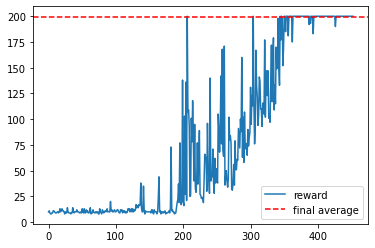

In [19]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.array(reward_list),label='reward')
plt.axhline(y=np.mean(np.array(reward_list)[-99:]), color='r', linestyle='--',label='final average')
plt.legend()

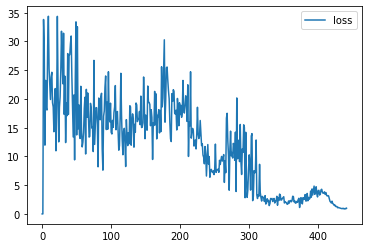

In [22]:
plt.plot(np.array(loss_list),label='loss')
plt.legend()